# Random Forest Regression

#### Random Forest Regression uses ensemble learning method for regression and combines predictions from multiple machine learning algorithms to make a more accurate prediction than a single model. We can use this model to predict resale price and then tune the hyperparameters of the model to achieve better predictions.

In [40]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

In [41]:
features = pd.read_csv('df_with_latlong.csv')
features.dtypes

month                            object
town                             object
flat_type                        object
block                            object
street_name                      object
storey_range                     object
floor_area_sqm                  float64
flat_model                       object
lease_commence_date               int64
remaining_lease                   int64
resale_price                    float64
Address                          object
Postal code                      object
nearest MRT                      object
distance to nearest MRT         float64
schools within 1km                int64
nearest mall                     object
mall nearest distance           float64
mall within 500m                  int64
mall within 1km                   int64
hawkers within 1km                int64
LatLong                          object
travel time to RP in minutes      int64
dtype: object

In [42]:
features.describe()

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,distance to nearest MRT,schools within 1km,mall nearest distance,mall within 500m,mall within 1km,hawkers within 1km,travel time to RP in minutes
count,148277.000000,148277.000000,148277.000000,1.482770e+05,148277.000000,148277.000000,1.482770e+05,148277.000000,148277.000000,148277.000000,148277.000000
mean,97.574923,1995.531957,74.293727,4.790543e+05,0.655203,5.527202,6.727853e-01,0.493563,1.769047,1.548952,48.040505
std,24.081911,13.742807,13.667899,1.657407e+05,0.425408,2.522944,3.827278e-01,0.717019,1.440924,1.589884,10.633175
min,31.000000,1966.000000,42.000000,1.400000e+05,0.002224,0.000000,1.860000e-09,0.000000,0.000000,0.000000,9.000000
25%,82.000000,1985.000000,63.000000,3.580000e+05,0.326404,4.000000,3.889378e-01,0.000000,1.000000,1.000000,42.000000
50%,94.000000,1996.000000,74.000000,4.500000e+05,0.563131,5.000000,6.044759e-01,0.000000,2.000000,1.000000,50.000000
75%,113.000000,2007.000000,86.000000,5.680000e+05,0.875608,7.000000,8.867143e-01,1.000000,3.000000,2.000000,56.000000
max,249.000000,2019.000000,97.000000,1.418000e+06,3.634699,16.000000,4.009099e+00,8.000000,17.000000,9.000000,76.000000


## Data Preparation

#### Before implementing the model, we split the columns 'LatLong' and 'Month' to get the 'Latitude', 'Longitude', 'Year' and 'Month' and converted them into float and integers respectively. We also dropped columns that are not needed.

#### After that, we conducted label-encoding for categorical variables, which converts each unique variable in a column to a number, so that they can be used in the model later.

In [43]:
features[['Latitude', 'Longitude']] = features['LatLong'].str.split(',', expand=True)

In [44]:
features[['year', 'month']] = features['month'].str.split('-', expand=True)

In [45]:
features["Latitude"] = features["Latitude"].astype(float)
features["Longitude"] = features["Longitude"].astype(float)
features["year"] = features["year"].astype('int64')
features["month"] = features["month"].astype('int64')

In [46]:
features = features.drop(["block", "street_name", "storey_range", "lease_commence_date", "LatLong", "Address", "Postal code"], axis = 1)
features

,month,town,flat_type,floor_area_sqm,flat_model,remaining_lease,resale_price,nearest MRT,distance to nearest MRT,schools within 1km,nearest mall,mall nearest distance,mall within 500m,mall within 1km,hawkers within 1km,travel time to RP in minutes,Latitude,Longitude,year
0,1,ANG MO KIO,2 ROOM,44.0,Improved,61,232000.0,Ang Mo Kio,1.007304,3,AMK Hub,0.997504,0,1,3,40,1.362005,103.853880,2017
1,1,ANG MO KIO,3 ROOM,67.0,New Generation,60,250000.0,Ang Mo Kio,1.271398,7,Broadway Plaza,0.868861,0,1,4,44,1.370966,103.838202,2017
2,1,ANG MO KIO,3 ROOM,67.0,New Generation,62,262000.0,Yio Chu Kang,1.069720,6,Broadway Plaza,1.525573,0,0,2,50,1.380709,103.835368,2017
3,1,ANG MO KIO,3 ROOM,68.0,New Generation,62,265000.0,Ang Mo Kio,0.946884,3,myVillage At Serangoon Garden,0.893796,0,1,3,43,1.366201,103.857201,2017
4,1,ANG MO KIO,3 ROOM,67.0,New Generation,62,265000.0,Yio Chu Kang,1.092577,5,Broadway Plaza,1.569307,0,0,2,47,1.381041,103.835132,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148272,3,YISHUN,5 ROOM,127.0,Improved,64,629000.0,Yishun,1.274187,3,Junction Nine,0.701213,0,1,1,50,1.428981,103.846473,2023
148273,3,YISHUN,5 ROOM,126.0,Improved,61,565000.0,Yishun,0.462724,9,Northpoint City,0.620131,0,2,1,48,1.433722,103.836068,2023
148274,3,YISHUN,5 ROOM,112.0,Improved,91,625000.0,Yishun,1.083451,7,Junction Nine,0.309025,1,1,1,55,1.432488,103.844367,2023
148275,3,YISHUN,5 ROOM,122.0,Improved,64,650000.0,Khatib,0.487889,5,Wisteria Mall,0.983081,0,1,0,47,1.413099,103.833868,2023


### Label Encoding

In [47]:
# Label encode categorical features
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
features["town"] = le.fit_transform(features["town"])
features["flat_type"] = le.fit_transform(features["flat_type"])
features["flat_model"] = le.fit_transform(features["flat_model"])
features["nearest MRT"] = le.fit_transform(features["nearest MRT"])
features["nearest mall"] = le.fit_transform(features["nearest mall"])
features

,month,town,flat_type,floor_area_sqm,flat_model,remaining_lease,resale_price,nearest MRT,distance to nearest MRT,schools within 1km,nearest mall,mall nearest distance,mall within 500m,mall within 1km,hawkers within 1km,travel time to RP in minutes,Latitude,Longitude,year
0,1,0,1,44.0,5,61,232000.0,1,1.007304,3,3,0.997504,0,1,3,40,1.362005,103.853880,2017
1,1,0,2,67.0,12,60,250000.0,1,1.271398,7,13,0.868861,0,1,4,44,1.370966,103.838202,2017
2,1,0,2,67.0,12,62,262000.0,122,1.069720,6,13,1.525573,0,0,2,50,1.380709,103.835368,2017
3,1,0,2,68.0,12,62,265000.0,1,0.946884,3,119,0.893796,0,1,3,43,1.366201,103.857201,2017
4,1,0,2,67.0,12,62,265000.0,122,1.092577,5,13,1.569307,0,0,2,47,1.381041,103.835132,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148272,3,25,4,127.0,5,64,629000.0,123,1.274187,3,52,0.701213,0,1,1,50,1.428981,103.846473,2023
148273,3,25,4,126.0,5,61,565000.0,123,0.462724,9,64,0.620131,0,2,1,48,1.433722,103.836068,2023
148274,3,25,4,112.0,5,91,625000.0,123,1.083451,7,52,0.309025,1,1,1,55,1.432488,103.844367,2023
148275,3,25,4,122.0,5,64,650000.0,58,0.487889,5,111,0.983081,0,1,0,47,1.413099,103.833868,2023


# Random Forest Regression Model

#### We train-test-split the data and run the random forest regression model. We calculated the accuracy and RMSE of the model

In [49]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['resale_price'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('resale_price', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [50]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [52]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [53]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# calculate R-squared score
r2 = r2_score(test_labels, predictions)
print('R-squared score:', r2)

# calculate explained variance
ev = explained_variance_score(test_labels, predictions)
print('Explained variance:', ev)

# Print out the mean squared error
mse = mean_squared_error(test_labels, predictions)
print('Mean Squared Error:', mse)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

R-squared score: 0.9555627580779864
Explained variance: 0.9555701364835809
Mean Squared Error: 1236504451.7092168
RMSE:  35163.965244397805


## Visualisations

#### We visualised the variable importances and found out that floor area affects the resale price the most, followed by travel time to Raffles Place MRT and remaining lease.

#### We also plot a scatter plot of predicted resale price against actual resale price and found that there is a rather positive linear relationship between them.

In [54]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: floor_area_sqm       Importance: 0.45
Variable: travel time to RP in minutes Importance: 0.21
Variable: remaining_lease      Importance: 0.1
Variable: year                 Importance: 0.08
Variable: Longitude            Importance: 0.03
Variable: flat_type            Importance: 0.02
Variable: Latitude             Importance: 0.02
Variable: month                Importance: 0.01
Variable: town                 Importance: 0.01
Variable: flat_model           Importance: 0.01
Variable: nearest MRT          Importance: 0.01
Variable: distance to nearest MRT Importance: 0.01
Variable: nearest mall         Importance: 0.01
Variable: mall nearest distance Importance: 0.01
Variable: schools within 1km   Importance: 0.0
Variable: mall within 500m     Importance: 0.0
Variable: mall within 1km      Importance: 0.0
Variable: hawkers within 1km   Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

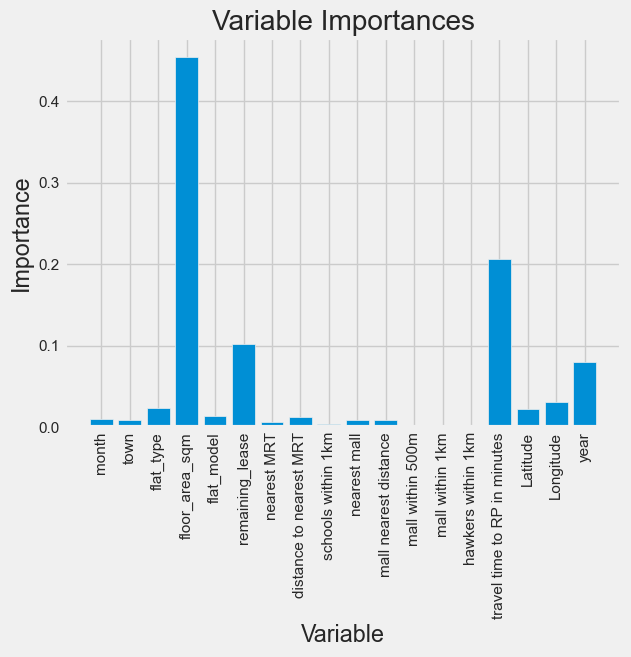

In [56]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

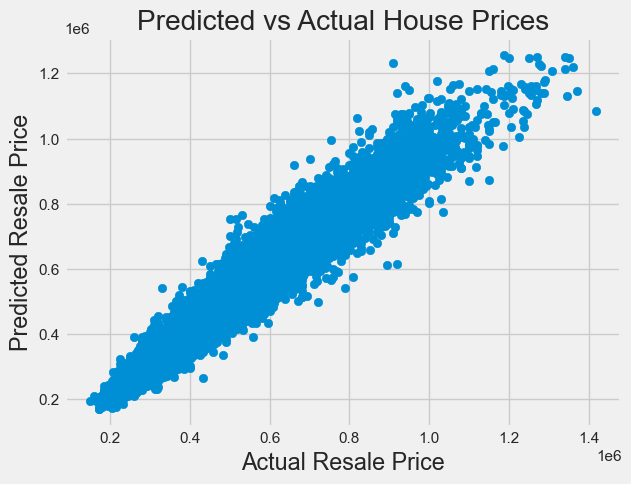

In [57]:
# create scatter plot of predicted vs actual values
plt.scatter(test_labels, predictions)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual House Prices')
plt.show()

# Tuning the hyperparameters

## Grid Search

In [58]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Creating a grid search object
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fitting the grid search object to the training data
grid_search.fit(train_features, train_labels)

# Printing the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Making predictions on the test set
y_pred = grid_search.predict(test_features)

# Calculating the mean squared error
mse = mean_squared_error(test_labels, y_pred)
print("Mean Squared Error: ", mse)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

Best parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best score:  1192535949.6918702
Mean Squared Error:  1181492957.34054
RMSE:  34372.85203966264


## Random Search

#### We found that random search produces a slightly lower RMSE than grid search

In [62]:
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [5, 10, 20, 30, 40, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Creating a randomized search object
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, scoring='neg_mean_squared_error', n_iter=10)

# Fitting the randomized search object to the training data
random_search.fit(train_features, train_labels)

# Printing the best parameters and score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", -random_search.best_score_)

# Making predictions on the test set
y_pred = random_search.predict(test_features)

# Calculating the mean squared error
mse = mean_squared_error(test_labels, y_pred)
print("Mean Squared Error: ", mse)
r2 = r2_score(test_labels, y_pred)
print('R-squared score:', r2)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

Best parameters:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 333}
Best score:  1207985881.0322573
Mean Squared Error:  1205530020.878866
R-squared score: 0.9566759107838277
RMSE:  34720.74338027436


# Tuned Model

#### We use the model that has had its hyperparameters tuned using Random Search to predict the resale price of HDBs. With the tuned model, it has a slightly higher R-squared score and lower RMSE than before.

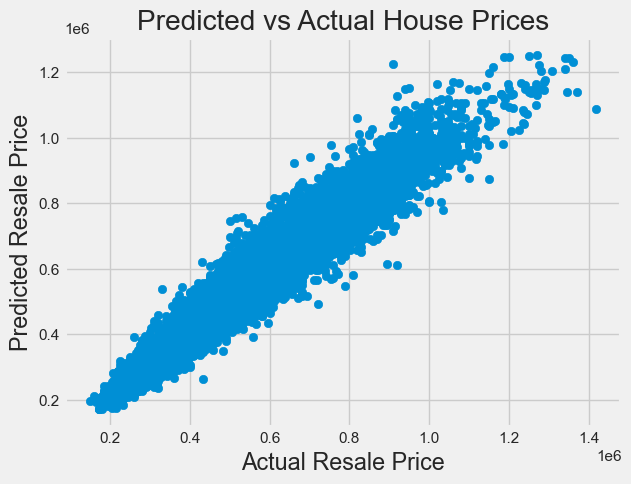

In [63]:
# create scatter plot of predicted vs true values
plt.scatter(test_labels, y_pred)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual House Prices')
plt.show()

# Conclusion

#### Overall, the random forest regression model produces a rather high accuracy in predicting resale prices of HDBs, and the tuned model using Random Search further increases its accuracy. Hence, this model might be suitable in predicting resale price for our project.